In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
%matplotlib inline

from scipy.spatial import Voronoi
from scipy import interpolate

from tyssue import Sheet
from tyssue import SheetGeometry
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.generation import hexa_cylinder, sheet_from_cell_centers, extrude
from tyssue.topology import type1_transition
from tyssue.draw import sheet_view

from tyssue.dynamics import model_factory, effectors
from tyssue.solvers.quasistatic import QSSolver
from tyssue import config

import math


### Initial tissue generation

In [2]:
points_xyz = hexa_cylinder(21, 15, 50, noise=0, capped=True)
sheet = sheet_from_cell_centers(points_xyz)
geom.update_all(sheet)


In [3]:
sheet.settings

{'lumen_vol': 1645549.821969129}

In [4]:
ipv.clear()
fig, mesh = sheet_view(
    sheet,
    mode='3D',
    face={
        "visible":True,
        "color": sheet.face_df.area
    }
)
ipv.squarelim()
ipv.show()

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [5]:
sheet.face_df.area.mean()

214.79360717933594

In [6]:
sheet.Nf

377

In [7]:
from polarity.dynamics import RadialTension, BarrierElasticity
smodel = model_factory([
    BarrierElasticity,
    effectors.LumenVolumeElasticity,
    effectors.FaceAreaElasticity,
    effectors.FaceContractility])


dyn_specs = {
    "settings": {
        "lumen_prefered_vol": sheet.settings["lumen_vol"]*1.1,
        "lumen_vol_elasticity": 1e-1/sheet.Nf,
        "threshold_length": 0.1,
        "barrier_ray":100,
    },
    "face": {
        "area_elasticity": 1.,
        #"prefered_area": sheet.face_df.area.median(), 
        "prefered_area": sheet.face_df.area.median(), 
        "contractility": 1.52,
    },
    "edge": {
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    },
    "vert":{
        "barrier_elasticity":280.0,
        "delta_rho":0
    }
}
## Those settings are set homogenously in the epithelium
sheet.update_specs(dyn_specs, reset=True)
geom.update_all(sheet)

Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column uz of the edge dataset with new specs


In [8]:
solver = QSSolver(with_t1=True, with_t3=True)
res = solver.find_energy_min(sheet, geom, smodel, options={"gtol": 1e-8})

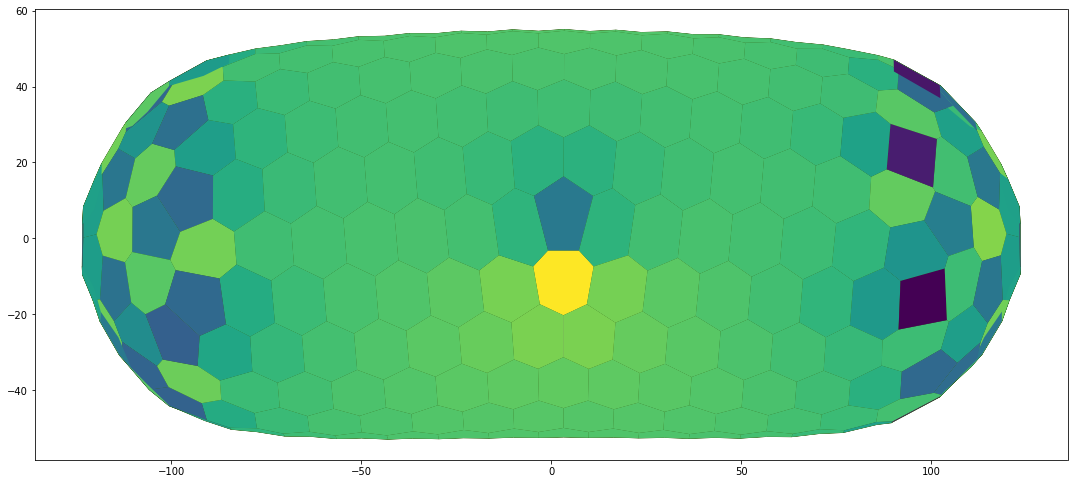

In [9]:
ipv.clear()
sheet_ = sheet.extract_bounding_box(y_boundary=(-10,150))
fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z','x'],
    face={
        "visible":True,
        "color": sheet_.face_df.area
    }
)
ipv.squarelim()
#ipv.show()
fig.set_size_inches(18.5, 10.5, forward=True)

In [10]:
from tyssue.utils.decorators import face_lookup
from tyssue.geometry.sheet_geometry import SheetGeometry
from tyssue.topology.sheet_topology import cell_division

from tyssue.behaviors.sheet.actions import contract, exchange, remove, relax


default_division_spec = {
    "face_id": -1,
    "face": -1,
    "growth_rate": 0.1,
    "critical_area": 3,
    "angle":None,
    "geom": geom,
}


@face_lookup
def division(sheet, manager, **kwargs):
    """Cell division happens through cell growth up to a critical volume,
    followed by actual division of the face.

    Parameters
    ----------
    sheet : a `Sheet` object
    manager : an `EventManager` instance
    face_id : int,
      index of the mother face
    growth_rate : float, default 0.1
      rate of increase of the prefered volume
    critical_vol : float, default 2.
      volume at which the cells stops to grow and devides

    """
    division_spec = default_division_spec
    division_spec.update(**kwargs)

    face = division_spec["face"]

    #division_spec["critical_area"] *= sheet.specs["face"]["prefered_area"]

    #print(sheet.face_df.loc[face, "area"], division_spec["critical_area"])

    #if sheet.face_df.loc[face, "area"] < division_spec["critical_area"]:
        #grow(sheet, face, division_spec["growth_rate"])
        #manager.append(division, **division_spec)
    #else:
    daughter = cell_division(sheet, face, division_spec["geom"], division_spec["angle"])
    sheet.face_df.loc[daughter, "id"] = sheet.face_df.id.max() + 1
    sheet.face_df.loc[daughter, 'prefered_area'] = (sheet.face_df.loc[face, 'prefered_area']/2 +
                                                     np.random.normal(scale=5))
    sheet.face_df.loc[face,'prefered_area'] -= (sheet.face_df.loc[daughter, 'prefered_area']
                                                +np.abs(np.random.normal(scale=1.5)))
        
        
def grow(sheet, face, growth_rate):
    sheet.face_df.loc[face,"prefered_area"] *= 1+growth_rate

In [11]:
from tyssue.behaviors.event_manager import EventManager

sheet.face_df['id']=sheet.face_df.index
manager = EventManager('face')

division_settings = {    
    "face_id": -1,
    "growth_rate": 1.5,
    "critical_area": 2,
    "geom": geom}

#entre pi/3 et 2pi/3
angle = np.random.random(sheet.Nf)*(np.pi/6)+(2*np.pi/6)

#f_index = sheet.face_df[(sheet.face_df.x>30.) | (sheet.face_df.x<-30.)].index.values
for i in sheet.face_df.index:
    division_settings.update(
        {
            'face_id': i,
            'angle':angle[i],
        }
    )
    manager.append(division, **division_settings)

i = 0
while manager.current:
    manager.update()

    manager.execute(sheet)

    res = solver.find_energy_min(sheet, geom, smodel, options={"gtol": 1e-8})

    # add noise on vertex position to avoid local minimal.
    sheet.vert_df[
        ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
    geom.update_all(sheet)
    i=i+1


/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


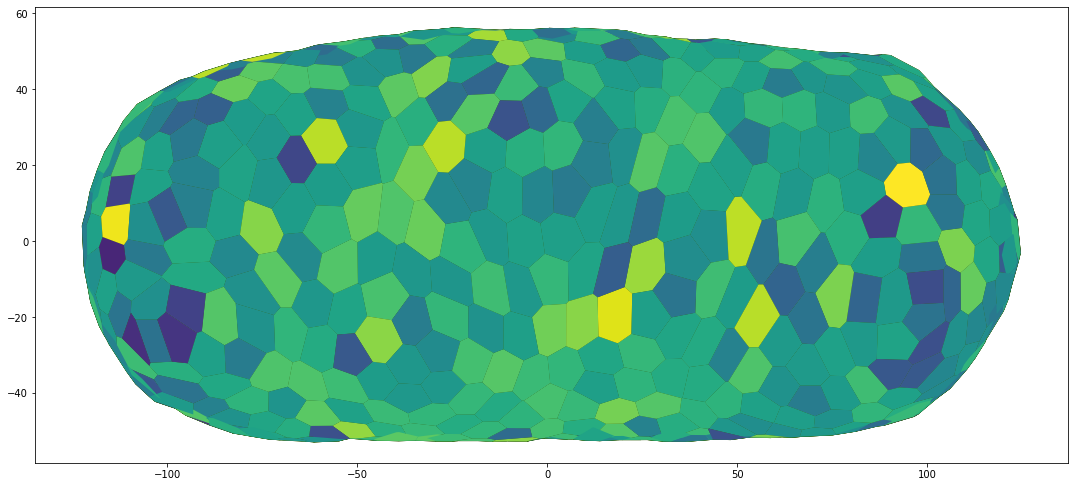

In [12]:
ipv.clear()
sheet_ = sheet.extract_bounding_box(y_boundary=(-10,150))
fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z','x'],
    face={
        "visible":True,
        "color": sheet_.face_df.area
    }
)
ipv.squarelim()
#ipv.show()
fig.set_size_inches(18.5, 10.5, forward=True)

In [13]:
sheet.face_df.area.sum()

73610.98547324653

In [14]:
sheet_first_division = sheet.copy()

In [15]:
sheet = sheet_first_division.copy()

In [13]:
from tyssue.behaviors.event_manager import EventManager

sheet.face_df['id']=sheet.face_df.index
manager = EventManager('face')

angle = np.random.random(sheet.Nf)*(np.pi/6)+(2*np.pi/6)

#f_index = sheet.face_df[(sheet.face_df.x>30.) | (sheet.face_df.x<-30.)].index.values
for i in sheet.face_df.index:
    division_settings.update(
        {
            'face_id': i,
            'angle':angle[i],
        }
    )
    manager.append(division, **division_settings)

i = 0
while manager.current:
    manager.update()

    manager.execute(sheet)

    res = solver.find_energy_min(sheet, geom, smodel, options={"gtol": 1e-8})

    # add noise on vertex position to avoid local minimal.
    sheet.vert_df[
        ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
    geom.update_all(sheet)
    i=i+1


/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


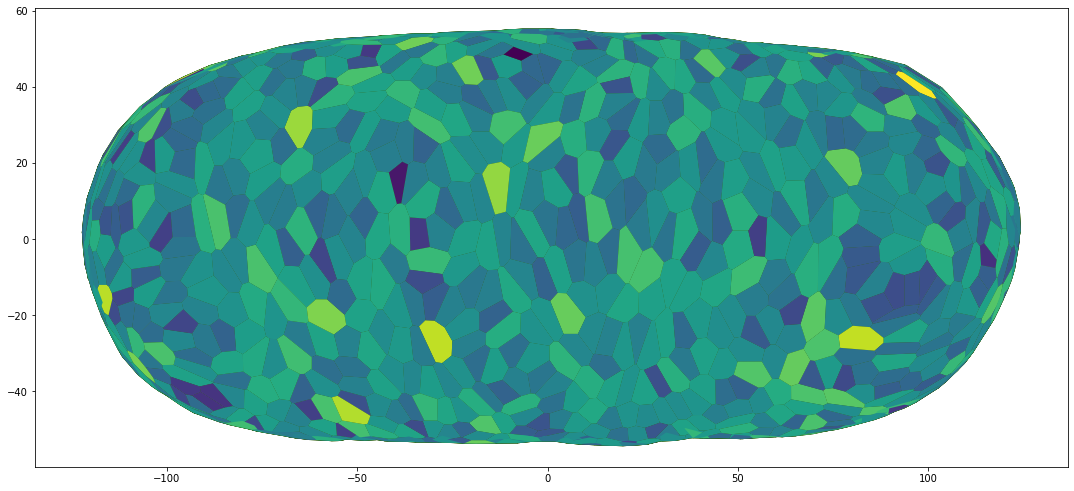

In [14]:
ipv.clear()
sheet_ = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z','y'],
    face={
        "visible":True,
        "color": sheet_.face_df.area
    }
)
ipv.squarelim()
fig.set_size_inches(18.5, 10.5, forward=True)
#ipv.show()

In [18]:
sheet.Nf

1651

In [19]:
sheet_second_division = sheet.copy()

In [20]:
sheet = sheet_second_division.copy()

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


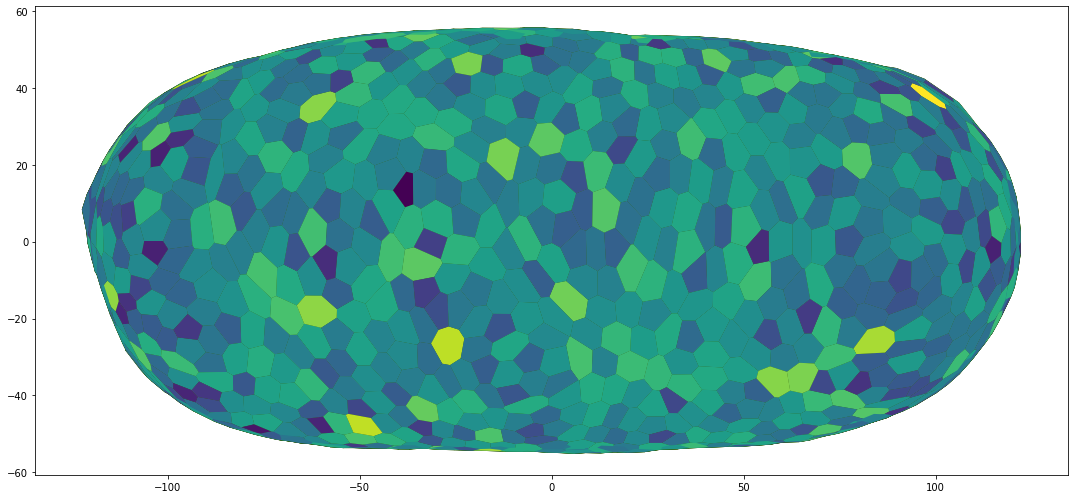

In [17]:
solver = QSSolver(with_t1=True, with_t3=True)

# add noise on vertex position to avoid local minimal.
sheet.vert_df[
    ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
geom.update_all(sheet)
res = solver.find_energy_min(sheet, geom, smodel, options={"gtol": 1e-8})
ipv.clear()
sheet_ = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z','y'],
    face={
        "visible":True,
        "color": sheet_.face_df.area
    }
)
ipv.squarelim()
fig.set_size_inches(18.5, 10.5, forward=True)
#ipv.show()

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


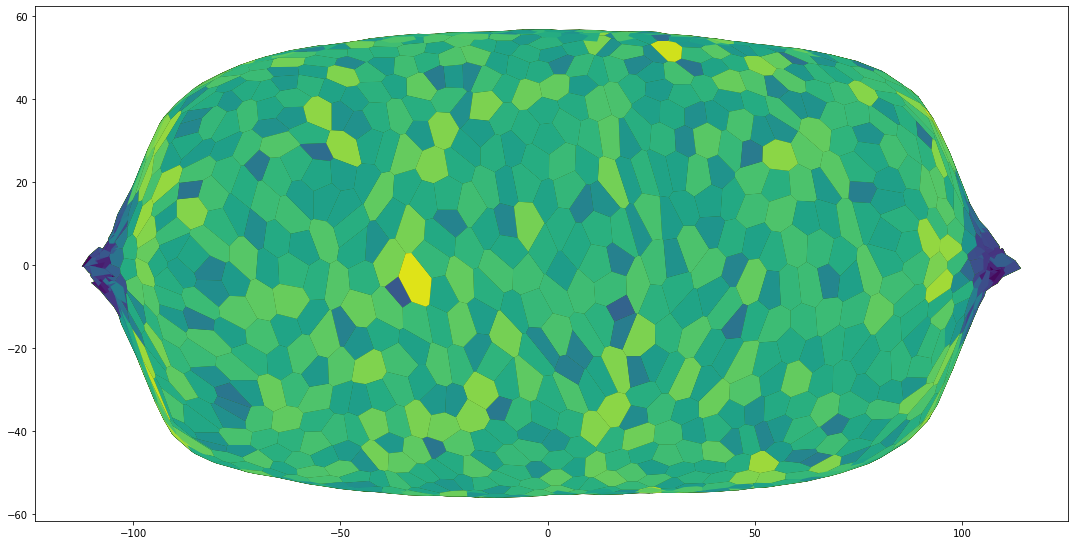

In [22]:
from polarity.dynamics import EllipsoidLameGeometry as geom
sheet.settings["barrier_ray"]=100

for i in (sheet.face_df.index.values):
    if sheet.face_df.loc[i, 'area']>80:
        sheet.face_df.loc[i, 'prefered_area']=sheet.face_df.loc[i, 'area']/2  ++ np.random.normal(scale=3)



res = solver.find_energy_min(sheet, geom, smodel, options={"gtol": 1e-8})
sheet_ = sheet.extract_bounding_box(x_boundary=(-10,150))
fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z','y'],
    face={
        "visible":True,
        "color": sheet_.face_df.area
    }
)
ipv.squarelim()
fig.set_size_inches(18.5, 10.5, forward=True)

(array([ 14.,  33.,  37.,  38., 142., 412., 598., 293.,  75.,   9.]),
 array([ 5.14054363, 11.66156865, 18.18259367, 24.70361868, 31.2246437 ,
        37.74566871, 44.26669373, 50.78771874, 57.30874376, 63.82976878,
        70.35079379]),
 <a list of 10 Patch objects>)

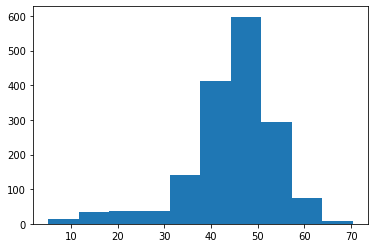

In [23]:
plt.hist(sheet.face_df.area)

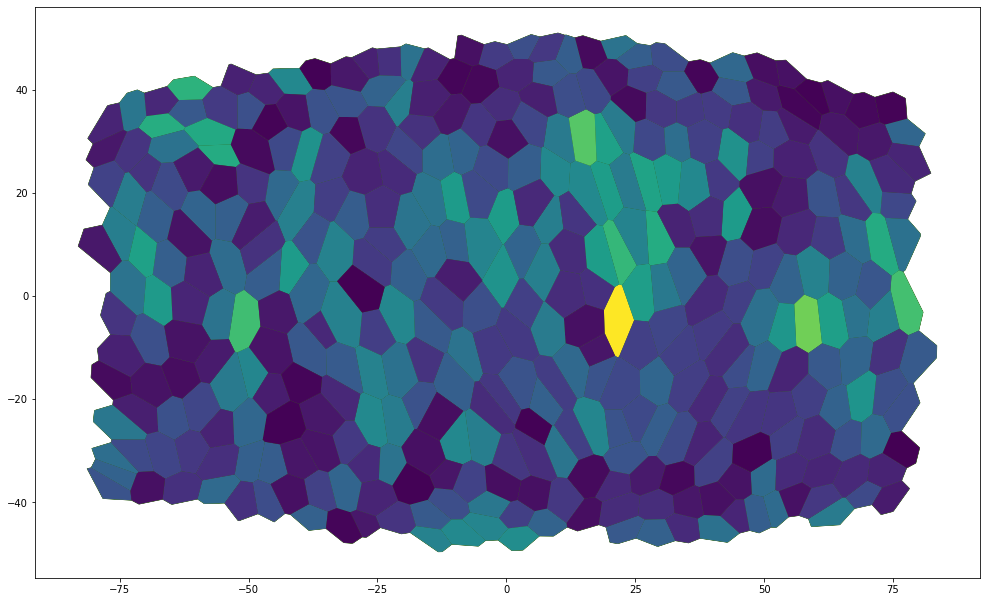

In [24]:
from tyssue.utils import ar_calculation

sheet_ = sheet.extract_bounding_box(x_boundary=(30,150), z_boundary=(-80,80))
fig, mesh = sheet_view(
    sheet_,
    mode='2D',
    coords=['z','y'],
    face={
        "visible":True,
        "color": ar_calculation(sheet_, ['z', 'y']).values
    }
)
ipv.squarelim()
fig.set_size_inches(18.5, 10.5, forward=True)

(array([92., 96., 64., 55., 36., 18.,  8.,  3.,  0.,  1.]),
 array([1.00061849, 1.14144983, 1.28228116, 1.42311249, 1.56394382,
        1.70477516, 1.84560649, 1.98643782, 2.12726916, 2.26810049,
        2.40893182]),
 <a list of 10 Patch objects>)

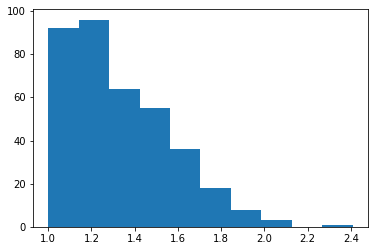

In [25]:
plt.hist(ar_calculation(sheet_, ['z', 'y']).values)

In [18]:
from tyssue.io import hdf5
hdf5.save_datasets('test_prepolarized_tissue2.hf5', sheet)

In [27]:
sheet_extract = sheet.extract_bounding_box(z_boundary=(-3.5,3.5))

In [28]:
ipv.clear()
fig, mesh = sheet_view(
    sheet_extract,
    mode='3D',
    face={
        "visible":True,
        "color": sheet_extract.face_df.area
    }
)
ipv.squarelim()
ipv.show()

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [29]:
sheet_extract.Nf

58

In [19]:
sheet.settings

{'lumen_vol': 1808975.6278749374,
 'lumen_prefered_vol': 1810104.804166042,
 'lumen_vol_elasticity': 0.00026525198938992045,
 'threshold_length': 0.1,
 'barrier_ray': 100}